In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import glob
import tensorflow as tf


In [2]:
dataset = '../dataset/'
IMAGE_WIDTH = 533
IMAGE_HEIGHT = 300
# read all images in the folder dataset
labels = ['mentah', 'matang']
images = []
for label in labels:
    for file in tqdm(glob.glob(dataset + label + '/*.jpg')):
        img = cv2.imread(file)
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = np.array(img)
        images.append([img_array, label])
print(len(images))

100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 124.75it/s]

192


In [3]:
def cv2_show(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def gaussian_blur(img):
    return cv2.GaussianBlur(img, (3, 3), 0)

def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def mask(img, label):
    if label == 'mentah':
        lower = np.array([0, 66, 0])
        upper = np.array([255, 255, 255])
    else:
        lower = np.array([0, 41, 0])
        upper = np.array([255, 255, 255])
    return cv2.inRange(img, lower, upper)





In [4]:
cv2_show(images[0][0])

# blur all images
blur_images = []

for i in range(len(images)):
    blur_images.append([gaussian_blur(images[i][0]), images[i][1]])
    
cv2_show(blur_images[0][0])

# convert to hsv
hsv_images = []

for i in range(len(blur_images)):
    hsv_images.append([hsv(blur_images[i][0]), images[i][1]])

cv2_show(hsv_images[0][0])


In [5]:
# mask all images
mask_images = []

for i in range(len(images)):
    mask_images.append([mask(hsv_images[i][0], images[i][1]), images[i][1]])

cv2_show(mask_images[0][0])

In [6]:
# erosion and dilation

segmented_images = []

for mask in mask_images:
    kernel = np.ones((3, 3),np.uint8)
    erosion = cv2.erode(mask[0], kernel,iterations = 1)
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    segmented_images.append([dilation, mask[1]])

cv2_show(segmented_images[0][0])


In [7]:
# final images v1
final_images = []

for i in range(len(segmented_images)):
    final_images.append([cv2.bitwise_and(images[i][0], images[i][0], mask=segmented_images[i][0]), images[i][1]])

# masih terdapat sisa-sisa background
cv2_show(final_images[0][0])


In [8]:
def gaussian_blur_v2(img):
    return cv2.GaussianBlur(img, (15, 15), 3)

def mask_v2(img, label):
    if label == 'mentah':
        lower = np.array([0, 100, 0])
        upper = np.array([255, 255, 255])
    else:
        lower = np.array([0, 95, 0])
        upper = np.array([255, 255, 255])
    return cv2.inRange(img, lower, upper)

segmented_images_v2 = []

for image in images:
    img = gaussian_blur_v2(image[0])
    img = hsv(img)
    img = mask_v2(img, image[1])

    kernel = np.ones((3, 3),np.uint8)
    if image[1] == 'mentah' :
        erosion = cv2.erode(img, kernel,iterations = 1)
        dilation = cv2.dilate(erosion,kernel,iterations = 1)
    else:
        erosion = cv2.erode(img, kernel,iterations = 2)
        dilation = cv2.dilate(erosion,kernel,iterations = 1)
    segmented_images_v2.append([dilation, image[1]])

final_images_v2 = []
for i in range(len(final_images)):
    final_images_v2.append([cv2.bitwise_and(images[i][0], images[i][0], mask=segmented_images_v2[i][0]), images[i][1]])
cv2_show(segmented_images_v2[0][0])
cv2_show(final_images_v2[0][0])
len(final_images_v2)



192

In [9]:
# save all final images v2 to file system
for i in range(len(final_images_v2)):
    cv2.imwrite('../dataset/segmented/' + final_images_v2[i][1] + '/' + str(i) + '.jpg', final_images_v2[i][0])
    
   


In [10]:
# access all segmented images
segmented_images = []
for label in labels:
    for file in tqdm(glob.glob('../dataset/segmented/' + label + '/*.jpg')):
        img = cv2.imread(file)
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = np.array(img)
        segmented_images.append([img_array, label])

print(len(segmented_images))



100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 467.93it/s]

192


In [11]:
def get_rgb(img):
    r = np.mean(img[:,:,2])
    g = np.mean(img[:,:,1])
    b = np.mean(img[:,:,0])
    return [r, g, b]

means = []
for image in segmented_images:
    rgb = get_rgb(image[0])
    means.append([rgb[0], rgb[1], rgb[2], image[1]])


In [12]:
# convert to dataframe
# Red, Green, Blue, Label
df = pd.DataFrame(means, columns=['Red', 'Green', 'Blue', 'Label'])
# show all data
df.head(len(df))

,Red,Green,Blue,Label
0,22.413233,25.272039,4.682639,mentah
1,21.745084,25.223809,7.268011,mentah
2,23.692477,26.899300,6.831220,mentah
3,26.973058,31.302858,7.302464,mentah
4,24.108849,28.455960,6.963684,mentah
...,...,...,...,...
187,39.737761,31.920344,12.184071,matang
188,32.105985,21.738881,9.159593,matang
189,35.278474,27.963089,10.807161,matang
190,35.819912,28.812889,11.014978,matang


In [13]:
# convert to csv
df.to_csv('../dataset/segmented/segmented.csv', index=False)

In [14]:
# change label to number
df['Label'] = df['Label'].map({'mentah': 0, 'matang': 1})

# show all data
df.head(len(df))

,Red,Green,Blue,Label
0,22.413233,25.272039,4.682639,0
1,21.745084,25.223809,7.268011,0
2,23.692477,26.899300,6.831220,0
3,26.973058,31.302858,7.302464,0
4,24.108849,28.455960,6.963684,0
...,...,...,...,...
187,39.737761,31.920344,12.184071,1
188,32.105985,21.738881,9.159593,1
189,35.278474,27.963089,10.807161,1
190,35.819912,28.812889,11.014978,1


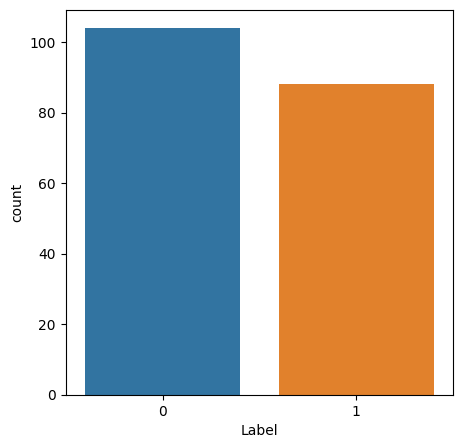

In [15]:
# plot target distribution
plt.figure(figsize=(5, 5))
sns.countplot(x='Label', data=df)
plt.show()


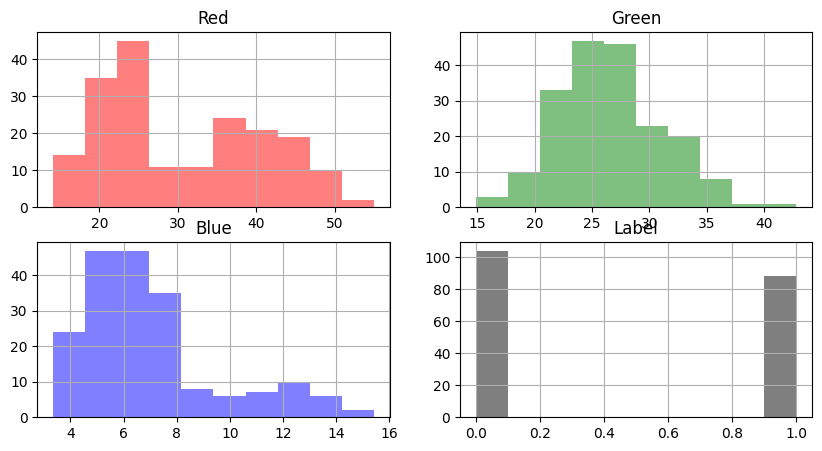

In [16]:
# sebaran data warna histogram
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.hist(df['Red'], bins=10, color='red', alpha=0.5)
plt.title('Red')
plt.grid(True)
plt.subplot(2, 2, 2)
plt.hist(df['Green'], bins=10, color='green', alpha=0.5)
plt.title('Green')
plt.grid(True)
plt.subplot(2, 2, 3)
plt.hist(df['Blue'], bins=10, color='blue', alpha=0.5)
plt.title('Blue')
plt.grid(True)
plt.subplot(2, 2, 4)
plt.hist(df['Label'], bins=10, color='black', alpha=0.5)
plt.title('Label')
plt.grid(True)
plt.show()

In [17]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(df[['Red', 'Green', 'Blue']], df['Label'], test_size=0.2, random_state=42)


In [18]:
# train model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, kernel_initializer='uniform', activation='relu', input_dim=3))
model.add(tf.keras.layers.Dense(30, kernel_initializer='uniform', activation='relu'))
model.add(tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=10, epochs=1000, verbose=0)

In [20]:
score, acc = model.evaluate(X_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)


4/4 [==============================] - 0s 4ms/step - loss: 1.0672e-07 - accuracy: 1.0000
Test score: 1.0672311390180766e-07
Test accuracy: 1.0


In [21]:
# save model
model.save('../model/final_acc_100.h5')

4/4 [==============================] - 0s 3ms/step - loss: 1.0672e-07 - accuracy: 1.0000
Test score: 1.0672311390180766e-07
Test accuracy: 1.0


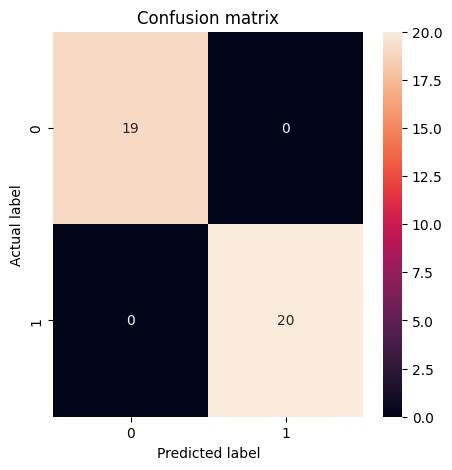

In [22]:
# confusion matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

score, acc = model.evaluate(X_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

